# Downsampling
## Idea:
* Two dataset variants have different sizes, need same size to compare other dataset properties
* -> sample down the larger one, i.e. draw a random sample
## Potential Risks:
* are other dataset properties affected by the downsampling?
    * Overlap
    * Error rate
    * Attribute-value frequencies, skewnesses

In [1]:
import math

import pandas as pd
# get the data
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.shape[0]

200000

Does downsampling affect overlap?

In [2]:
from dataset_properties import get_overlap, split_and_get_overlap

split_and_get_overlap(df)

0.2

In [3]:
sample = df.sample(100_000, random_state=42)
split_and_get_overlap(sample)

0.1007

In [4]:
sample = df.sample(50_000, random_state=42)
split_and_get_overlap(sample)

0.04996

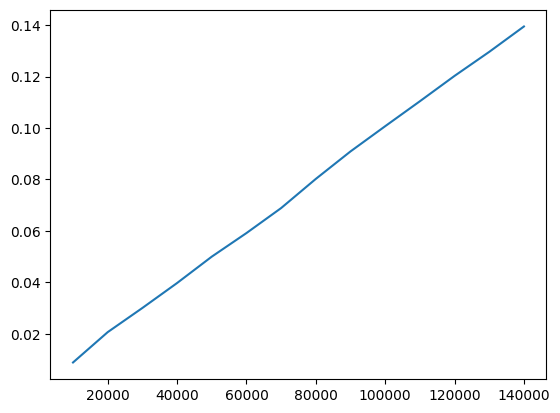

In [5]:
import matplotlib.pyplot as plt

sizes = [*range(10_000, 150_000, 10_000)]
overlaps = [split_and_get_overlap(df.sample(size, random_state=42))
            for size in sizes]
plt.plot(sizes, overlaps)

### Observation:
Sample size and overlap are linearly correlated

### Solution Approach:
Split dataset into matches and non-matches, draw from each, then recombine
A.k.a use random_sample method from dataset_modifier and specify overlap

In [2]:
from dataset_modifier import random_sample, split_by_source_id

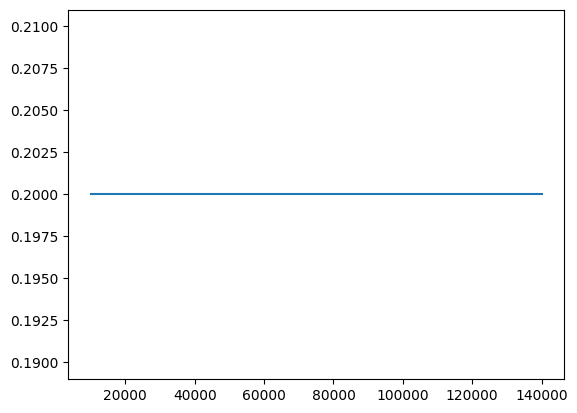

In [6]:
df_a, df_b = split_by_source_id(df)
sizes = [*range(10_000, 150_000, 10_000)]
overlaps = [split_and_get_overlap(random_sample(df_a, df_b, size, seed=42))
            for size in sizes]
plt.plot(sizes, overlaps)

### It works! :)

Does this downsampling method affect other ds properties?
#### Error Rate
##### Avg edit distance

In [7]:
from error_rates import get_all_errors, avg_edit_distance, count_errors, get_attrs

In [8]:
errors = get_all_errors(df, avg_edit_distance, get_attrs(col_names))

<AxesSubplot: >

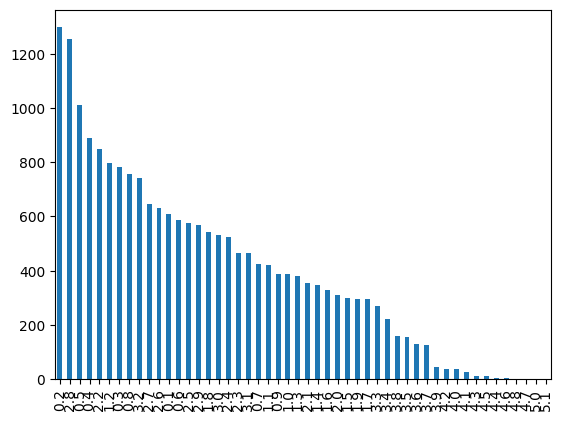

In [9]:
errors_round = errors.map(lambda e: round(e, 1))
errors_round.value_counts().sort_values(ascending=False).plot.bar()

In [10]:
errors_round.value_counts().skew()

0.7513348913756545

In [11]:
sample = random_sample(df_a, df_b, 100_000, seed=42)
errors_sample = get_all_errors(sample, avg_edit_distance, get_attrs(col_names))
errors_round_sample = errors_sample.round(1)

<AxesSubplot: >

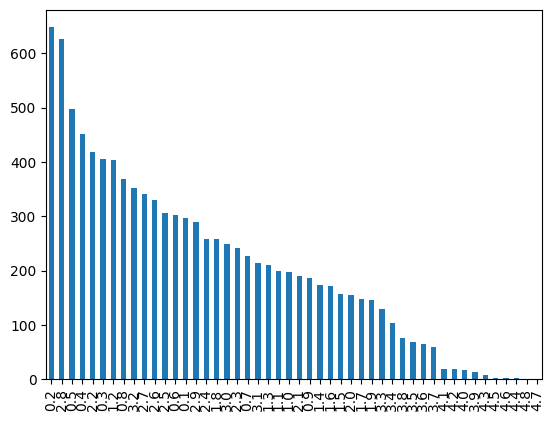

In [12]:
errors_round_sample.value_counts().sort_values(ascending=False).plot.bar()

In [13]:
errors_round_sample.value_counts().skew()

0.7116940526568216

In [13]:
from scipy.stats import ttest_ind, describe

In [15]:
ttest_ind(errors_round, errors_round_sample)

Ttest_indResult(statistic=0.8300236287242493, pvalue=0.4065320295958823)

In [16]:
ttest_ind(errors, errors_sample)

Ttest_indResult(statistic=0.8439522924187909, pvalue=0.39870279512286044)

### Observation:
For random subset size 100k, the avg edit distances are not significantly different

In [17]:
sizes = [*range(10_000, 150_000, 10_000)]
attrs = get_attrs(col_names)
p_values = [ttest_ind(get_all_errors(df, avg_edit_distance, attrs),
                      get_all_errors(random_sample(df_a, df_b, size, seed=42), avg_edit_distance, attrs)).pvalue for size in sizes]

In [18]:
any([p < 0.1 for p in p_values])

False

In [22]:
min(p_values)

0.25400586198341774

### Observation:
For any size in {10k, 20k, ..., 150k} the avg edit distances are not significantly different

##### Error count

In [19]:
p_values = [ttest_ind(get_all_errors(df, count_errors, attrs),
                      get_all_errors(random_sample(df_a, df_b, size, seed=42), count_errors, attrs)).pvalue for size in sizes]

In [20]:
any([p < 0.1 for p in p_values])

False

In [21]:
min(p_values)

0.25400586198341774

## Observation:
#### Error rate not influenced by downsampling

## Question:
### How are attribute value frequencies influenced by downsampling?

#### Skewness of first name

In [118]:
def compare_skews(df1: pd.DataFrame, df2: pd.DataFrame, attr_name: str, sample_size: int, iterations: int):
    min_size = min(df1.shape[0], df2.shape[0])
    df1_sample, df2_sample = [df.sample(min_size) for df in (df1, df2)]  # need two equally sized samples, otherwise the variance will not be equal
    skews1, skews2 = [[df[attr_name].sample(sample_size, random_state=seed).value_counts().skew()
                       for seed in range(iterations)]
                      for df in (df1_sample, df2_sample)]
    return ttest_ind(skews1, skews2).pvalue

In [119]:
df_sampled = random_sample(df_a, df_b, 50_000, seed=42)
compare_skews(df, df_sampled, "FIRSTNAME", 1000, 1000)

1.3982799934237615e-06

In [62]:
df_sampled = random_sample(df_a, df_b, 15_000, seed=42)
compare_skews(df, df_sampled, "FIRSTNAME", 1000, 1000)

0.5767003883942488

In [63]:
df_sampled = random_sample(df_a, df_b, 11_000, seed=42)
compare_skews(df, df_sampled, "FIRSTNAME", 1000, 100)

0.6768346624526926

In [64]:
df_sampled = random_sample(df_a, df_b, 5000, seed=42)
compare_skews(df, df_sampled, "FIRSTNAME", 1000, 100)

0.028226208677761443

In [65]:
df_sampled = random_sample(df_a, df_b, 50_000, seed=42)
compare_skews(df, df_sampled, "FIRSTNAME", 10_000, 100)

0.08640976778841257

### Observation:
Downsampling does not influence skewness of first name if downsampling_size >> (sample_size in compare method)

### Skewness of last name

In [70]:
df_sampled = random_sample(df_a, df_b, 100_000, seed=42)
compare_skews(df, df_sampled, "LASTNAME", 5000, 1000)

0.36142983105220783

In [114]:
df_sampled = random_sample(df_a, df_b, 50_000, seed=42)
compare_skews(df, df.sample(15_000), "LASTNAME", 10_000, 1000)

5.615566678767309e-201

In [115]:
skews1, skews2 = [[df["FIRSTNAME"].sample(10_000, random_state=seed).value_counts().skew()
                       for seed in range(1000)]
                      for df in (df, df.sample(15_000))]

In [116]:
describe(skews1)

DescribeResult(nobs=1000, minmax=(7.944169414740913, 9.967781291470358), mean=8.858960652745031, variance=0.10468497978797489, skewness=0.21115252662227504, kurtosis=0.00017616731422309684)

In [117]:
describe(skews2)

DescribeResult(nobs=1000, minmax=(8.291542139628818, 9.555131273145237), mean=8.892752977226795, variance=0.03975121720703686, skewness=0.06864380488897288, kurtosis=-0.15387664289017078)

In [71]:
df_sampled.LASTNAME.value_counts().skew()

28.749782515545313

In [88]:
df.FIRSTNAME.value_counts().skew()

22.40701130969864

In [89]:
df.sample(50_000).FIRSTNAME.value_counts().skew()

14.460993405603181

In [113]:
df.sample(10_000).FIRSTNAME.value_counts().skew()

8.985692385674708

In [109]:
df.sample(15_000).sample(10_000).FIRSTNAME.value_counts().skew()

7.987249666612497

In [11]:
import matplotlib.pyplot as plt

In [6]:
sizes = range(10_000, 200_000, 10_000)

In [151]:
x = []
y = []
for size in sizes:
    sample = df.sample(size)
    for _ in range(100):
        x.append(size)
        y.append(sample.sample(9000).FIRSTNAME.value_counts().skew())

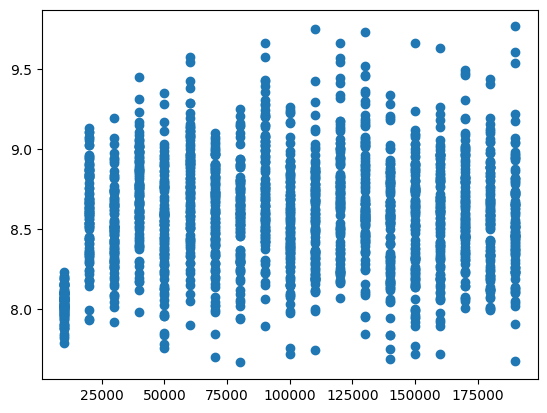

In [152]:
plt.scatter(x, y)

### Observation:
Problem with current comparison method.
When comparing skewnesses of many sub-samples of two random samples, the t-test may say they are different (see chart above), although they were created by the same random distr. This happens especially with smaller subsets.

### Solution approach:
for each sub-sample, draw a new underlying sample

In [22]:
from tqdm import tqdm

x = []
y = []
for size in tqdm(sizes):
    for _ in range(100):
        #sample = df.sample(size)
        sample = df  # replaced the line above with this one, to check if the reason for the low pvalues was actually the size of the underlying sample
        x.append(size)
        y.append(sample.sample(9000).FIRSTNAME.value_counts().skew())

100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


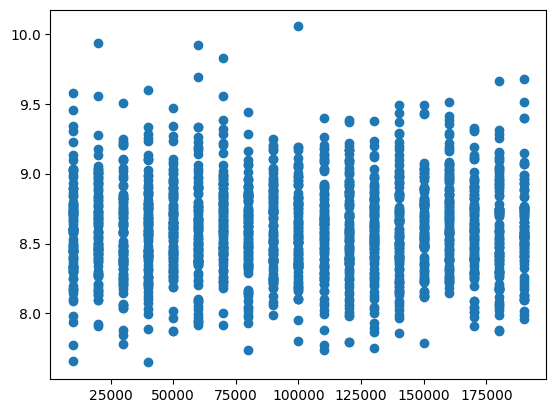

In [23]:
plt.scatter(x, y)

In [24]:
pvals = []
for size1 in sizes:
    for size2 in sizes:
        if size1 >= size2:
            continue
        skews1 = [skew for s, skew in zip(x, y) if s == size1]
        skews2 = [skew for s, skew in zip(x, y) if s == size2]
        pvals.append((size1, size2, ttest_ind(skews1, skews2).pvalue))
sorted(pvals, key=lambda x: x[2])

[(30000, 160000, 0.0014847990452997626),
 (130000, 160000, 0.003690354461688145),
 (30000, 70000, 0.007768596720901196),
 (80000, 160000, 0.008323502395329287),
 (110000, 160000, 0.009508864884383243),
 (160000, 180000, 0.010666697930019611),
 (160000, 170000, 0.012497313097131748),
 (40000, 160000, 0.012749937674977367),
 (10000, 160000, 0.013718300202575471),
 (100000, 160000, 0.014411778191016564),
 (70000, 130000, 0.018312284681375406),
 (140000, 160000, 0.028213123716241358),
 (160000, 190000, 0.028715116403531925),
 (90000, 160000, 0.02895994380152592),
 (70000, 80000, 0.035945387703077966),
 (60000, 160000, 0.03693400740927084),
 (70000, 110000, 0.03814282292495938),
 (120000, 160000, 0.039978428787716624),
 (70000, 180000, 0.04080450958071616),
 (40000, 70000, 0.049367829241822786),
 (70000, 170000, 0.050982704026330844),
 (50000, 160000, 0.05099181440488377),
 (10000, 70000, 0.052276147487570895),
 (70000, 100000, 0.05513192172725216),
 (20000, 160000, 0.05954245298254833),
 (

### There is something wrong with this method of comparison
As you see above, even when drawing equally sized samples from the same underlying dataset (100 times), there are still some very low pvalues.
Maybe 100 times is too little or the sample sizes are generally too small.
For now try, with 1000 iterations instead of 100 and see if anything changes.

In [25]:
x = []
y = []
for size in tqdm(sizes):
    for _ in range(1000):
        #sample = df.sample(size)
        sample = df  # replaced the line above with this one, to check if the reason for the low pvalues was actually the size of the underlying sample
        x.append(size)
        y.append(sample.sample(1200).FIRSTNAME.value_counts().skew())

100%|██████████| 19/19 [02:20<00:00,  7.37s/it]


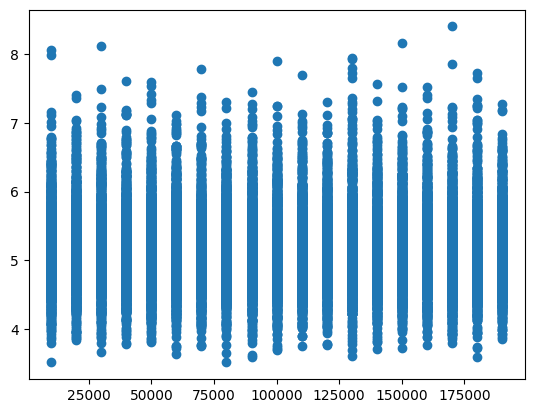

In [26]:
plt.scatter(x, y)

In [27]:
pvals = []
for size1 in sizes:
    for size2 in sizes:
        if size1 >= size2:
            continue
        skews1 = [skew for s, skew in zip(x, y) if s == size1]
        skews2 = [skew for s, skew in zip(x, y) if s == size2]
        pvals.append((size1, size2, ttest_ind(skews1, skews2).pvalue))
sorted(pvals, key=lambda x: x[2])

[(100000, 130000, 0.0001388488896321009),
 (70000, 130000, 0.000563339239704235),
 (100000, 150000, 0.003157740525496151),
 (50000, 130000, 0.004575682113861615),
 (30000, 100000, 0.005225126357659706),
 (100000, 190000, 0.005693712504150073),
 (130000, 170000, 0.008068168967544587),
 (70000, 150000, 0.0100952461988653),
 (120000, 130000, 0.01313506177443765),
 (60000, 100000, 0.013388271445890661),
 (30000, 70000, 0.015922798573517218),
 (70000, 190000, 0.0173625097325298),
 (20000, 100000, 0.018717418092554797),
 (130000, 140000, 0.020791839610904573),
 (90000, 130000, 0.020940701105632207),
 (110000, 130000, 0.021903799522646743),
 (130000, 160000, 0.024962817016035643),
 (10000, 130000, 0.03517694048570226),
 (80000, 130000, 0.036829517878400074),
 (130000, 180000, 0.0369306132585431),
 (60000, 70000, 0.036938832471439684),
 (40000, 100000, 0.03956179141057483),
 (20000, 70000, 0.04934414820147239),
 (50000, 150000, 0.050493328780039495),
 (40000, 130000, 0.06879797497205789),
 (80

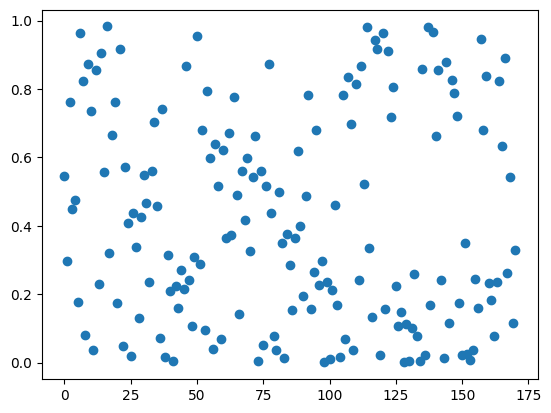

In [28]:
plt.scatter(x=range(len(pvals)), y=[p[2] for p in pvals])